---
# 3 REGRESSION APPROACHES (LEAFToolbox-SL2P + ALR)

This notebook contains code blocks to generate predictions based on three different treatment methods, which are as follows:
1. SL2P10 – using only the output from SL2P10_10m
2. LARS + Regression Tree – using feature selection (LARS) and smileCART (GEE function)
3. LARS + Neural Network – as implemented by Hemit in ALR_client_side
---

In [1]:
import ee
import time
import math
import csv
import json
import os
import numpy as np
import pandas as pd
import folium ; from folium import plugins
import matplotlib.pyplot as plt
import scipy ; from scipy import stats
import scipy.io as sio
import sklearn as skl ; from sklearn import linear_model ; from sklearn import preprocessing
import tensorflow as tf
import pickle
from collections import OrderedDict
from PIL import Image

# import custom modules (files must be in same directory as this notebook)
import feature_collections as fc
import image_bands as ib
import wrapper_nets as wn
import ee_functions as ee_func
import ALR_functions as alr

In [2]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AX4XfWigL1B1FR7c9cIWXQIVtz3iQGF_vhLv2N14e7SP-hIbiOcwF5LoSFw



Successfully saved authorization token.


---
# Prelim: Define dictionaries

In [3]:
# ----------------------------
# INPUT PARAMETERS (TO MODIFY)
# ----------------------------

# variable name
# one of: 'Surface_Reflectance','Albedo','fAPAR','fCOVER','LAI','CCC','CWC','DASF'
outputName = 'LAI'

# site selection
# one of: 'Geraldton', 'FoxCreek', 'Kouchibouguac', 'Ottawa'
siteSelect = 'FoxCreek'

### Collection options

In [4]:
# ---------------------------------------------------------------------
# set parameters based on user-defined parameters above (do not modify)
# ---------------------------------------------------------------------
outputParams = {
    'fAPAR': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 1
    },
    'fCOVER': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 1
    },
    'LAI': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 8
    }
}

outputScale = outputParams[outputName]['outputScale']
outputOffset = outputParams[outputName]['outputOffset']
outputMax = outputParams[outputName]['outputMax']
responseBand = 'estimate'+outputName

siteParams = {
    # Geraldton, ON
    'Geraldton': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200811T164849_20200811T165525_T16UEA'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-86, 49.5], \
                          [-86, 50], \
                          [-85.5, 50], \
                          [-85.5, 49.5]]]),
        'mapCenter': [-85.75, 49.75]
    },
    # Fox Creek, AB
    'FoxCreek': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20210825T185919_20210825T190431_T11UNA'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-117, 54], \
                          [-117, 55], \
                          [-115, 55], \
                          [-115, 54]]]),
        'mapCenter': [-116.8, 54.4]
        
    },
    # Kouchibouguac, NB
    'Kouchibouguac': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200905T151701_20200905T151829_T20TLS'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-65, 46], \
                          [-65, 47], \
                          [-64, 47], \
                          [-64, 46]]]),
        'mapCenter': [-64.5, 46.5]
    },
    # Ottawa, ON
    'Ottawa': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200801T155911_20200801T160644_T18TVQ'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-75, 45], \
                          [-75, 46], \
                          [-74, 46], \
                          [-74, 45]]]),
        'mapCenter': [-74.5, 45.5]
    }
}

mapBounds = siteParams[siteSelect]['mapBounds']
mapCenter = siteParams[siteSelect]['mapCenter']
testImage = siteParams[siteSelect]['testImage']

# other filters
maxCloudcover = 10

# export parameters
exportFolder = siteSelect+'_'+outputName
exportDataType = 'int'
exportScale = 20


COLLECTION_OPTIONS = {
    # Sentinel 2 using 20 m bands:
    'COPERNICUS/S2_SR': {
      "name": 'COPERNICUS/S2_SR',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.s2_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.s2_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(fc.s2_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.s2_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.s2_createFeatureCollection_legend()),
      "numVariables": 7
    },
    # Sentinel 2 using 10 m bands:
    'COPERNICUS/S2_SR_10m': {
      "name": 'COPERNICUS/S2_SR',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.s2_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.s2_createFeatureCollection_legend()),
      "numVariables": 7
    }
}

VIS_OPTIONS = {
    'fAPAR': {
        "COPERNICUS/S2_SR": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'fCOVER': {
        "COPERNICUS/S2_SR": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
        }
    },
    'LAI': {
        "COPERNICUS/S2_SR": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    }
}

---
# 1 – SL2P10

In [5]:
# parse the networks
colName = 'COPERNICUS/S2_SR_10m'
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [6]:
# performs same procedure as block 6 above, using SL2P10 network
# applies algorithm to 10 m bands ; generates a 10 m map

# filter collection and add ancillary bands
input_collection_10m = ee.ImageCollection(testImage) \
                     .map(lambda image: ib.addDate(image)) \
                     .map(lambda image: image.clip(mapBounds)) \
                     .map(lambda image: ib.s2MaskClear(image)) \
                     .map(lambda image: ib.s2MaskLand(image)) \
                     .map(lambda image: ib.addS2Geometry(colOptions, image))

# get partition used to select network
partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')

# pre process input imagery and flag invalid inputs
input_collection_10m = input_collection_10m.map(lambda image: ib.s2MaskLand(image)) \
                                           .map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                           .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))

# apply networks to produce mapped parameters
estimateSL2P_10m = input_collection_10m.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
uncertaintySL2P_10m = input_collection_10m.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))

# scale and offset mapped parameter bands
estimateSL2P_10m = estimateSL2P_10m.map(lambda image: image.addBands(image.select("estimate"+outputName) \
                                                             .multiply(ee.Image.constant(outputScale)) \
                                                             .add(ee.Image.constant(outputOffset)), overwrite = True))
uncertaintySL2P_10m = uncertaintySL2P_10m.map(lambda image: image.addBands(image.select("error"+outputName) \
                                                                   .multiply(ee.Image.constant(outputScale)) \
                                                                   .add(ee.Image.constant(outputOffset)),overwrite = True))


# produce final export collection
export_collection_10m = input_collection_10m.combine(estimateSL2P_10m).combine(uncertaintySL2P_10m)

image_output_names_10m = ([name+"_"+outputName+"_10m" for name in export_collection_10m.toList(export_collection_10m.size()).map(lambda image: ee.Image(image).id()).getInfo()])
ee_func.displayImage(export_collection_10m.mosaic().select('estimate'+outputName),0+outputOffset,10*outputScale+outputOffset, mapBounds)

# ALR

a few notes:
1. the responseBand from the above step doesn't have a geometry associated with it (only happens after being uploaded to GEE) so the image will have to be defined from existing GEE asset for the remaining steps even though the same image was created as inputImage (should be identical except for geometry)

In [7]:
# order of bands from SL2P output:
# 00-11: 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 
# 12-19: 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 
# 20-26: 'QA10', 'QA20', 'QA60', 'date', 'cosVZA', 'cosSZA', 'cosRAA', 
# 27-32: 'estimateLAI', 'partition', 'networkID', 'errorLAI', 'partition_1', 'networkID_1'

# define 10m band input image ; name bands of inputImage and scale response band
inputImage = ee.Image('users/kateharvey/'+siteSelect+'_'+outputName).select(1,2,3,7,22,23,27,28,29,30,31,32)
inputImage_bands = ee.List(['B2', 'B3', 'B4', 'B8', 'QA60', 'date', 'estimate'+outputName, 'partition', 'networkID', 'error'+outputName, 'partition_1', 'networkID_1'])
inputImage = inputImage.rename(inputImage_bands)

In [8]:
# Only include VIs that use B2, B3, B4, B8 to create a 10 m product
input_VI_definition = ee.List([# "RAW_B2  = b('B2')",
                             # "RAW_B3  = b('B3')",
                             # "RAW_B4  = b('B4')",
                             # "RAW_B8  = b('B8')",
                               "GI      = b('B3')/b('B4')",
                             # "RVI3    = b('B4')/b('B6')",
                             # "SR3     = b('B5')/b('B4')",
                             # "GM1     = b('B6')/b('B3')",
                             # "GM2     = b('B6')/b('B5')",
                             # "SR2     = b('B7')/b('B3')",
                             # "PSSR    = b('B7')/b('B4')",
                               "SGI     = b('B8')/b('B4')",
                             # "MSI     = b('B11')/b('B7')",
                             # "II      = b('B11')/b('B12')",
                               "GVI     = (b('B8')/b('B3'))-1",
                             # "PSRI    = (b('B4')-b('B3'))/b('B6')",
                               "NDVI3   = ((b('B8')-b('B4'))/(b('B8')))+b('B4')",
                             # "SR5     = 1/b('B5')",
                             # "SR6     = b('B4')/(b('B3')*b('B5'))",
                             # "SR7     = b('B8')/(b('B3')*b('B5'))",
                             # "IPVI    = b('B7')/(b('B7')+b('B4'))",
                             # "ARI     = (1/b('B3'))-(1/b('B5'))",
                             # "ARI2    = b('B7')*((1/b('B3'))-(1/b('B5')))",
                               "NDVI    = (b('B8')-b('B4'))/(b('B8')+b('B4'))",
                               "GNDVI   = (b('B8')-b('B3'))/(b('B8')+b('B3'))",
                             # "NDWI    = (b('B8')-b('B11'))/(b('B8')+b('B11'))",
                             # "NDREVI  = (b('B8')-b('B5'))/(b('B8')+b('B5'))",
                               "NDGI    = (b('B3')-b('B4'))/(b('B3')+b('B4'))",
                             # "NDI1    = (b('B7')-b('B5'))/(b('B7')-b('B4'))",
                             # "NDI2    = (b('B8')-b('B5'))/(b('B8')-b('B4'))",
                             # "RENDVI  = (b('B6')-b('B5'))/(b('B6')+b('B5'))",
                             # "OSAVI   = (1.16*(b('B7')-b('B4')))/(b('B7')+b('B4')+0.61)",
                             # "NMDI    = (b('B8')-(b('B11')-b('B12')))/(b('B8')+(b('B11')-b('B12')))",
                             # "HI      = ((b('B3')-b('B5'))/(b('B3')+b('B5')))-0.5*b('B5')",
                             # "GVSP    = (-0.283*b('B3') - 0.66*b('B4') + 0.577*b('B6') + 0.388*b('B8'))/(0.433*b('B3') - 0.632*b('B4') + 0.586*b('B6') + 0.264*b('B8A'))",
                             # "MCARI   = ((b('B5')-b('B4'))-0.2*(b('B5')-b('B3')))*(b('B5')/b('B4'))",
                             # "TCARI   = 3*((b('B5')-b('B4'))-0.2*(b('B5')-b('B3'))*(b('B5')/b('B4')))",
                               "EVI     = 2.5*((b('B8')-b('B4'))/(b('B8')+6*b('B4')-7.5*b('B3')+1))",
                               "EVI2    = 2.5*((b('B8')-b('B4'))/(b('B8')+2.4*b('B4')+1))",
                               "RDVI    = (b('B8')-b('B4'))/((b('B8')+b('B4'))**0.5)",
                               "MSR     = ((b('B8')/b('B4'))-1)/((b('B8')/b('B4'))**0.5+1)",
                             # "MSAVI   = 0.5*(2*b('B7')+1-((2*b('B7')+1)**2-8*(b('B7')-b('B4')))**0.5)",
                               "MSAVI2  = 0.5*(2*b('B8')+1-((2*b('B8')+1)**2-8*(b('B8')-b('B4')))**0.5)",
                             # "MCARI2  = (1.5*(2.5*(b('B7')-b('B4'))-1.3*(b('B7')-b('B3'))))/((((2*b('B7')+1)**2)-(6*b('B7')-5*(b('B4')**0.5))-0.5)**0.5)",
                             # "MTVI2   = (1.5*(1.2*(b('B7')-b('B3'))-2.5*(b('B4')-b('B3'))))/(((2*b('B7')+1)**2-(6*b('B7')-5*b('B4'))-0.5)**0.5)",
                             # "MSR2    = ((b('B7')/b('B4'))-1)/(((b('B7')/b('B4'))+1)**0.5)",
                               "NLI     = ((b('B8')**2)-b('B4'))/((b('B8')**2)+b('B4'))"])

# names of bands to pass to ALR method (excluding metadata and other non-spectral bands)
input_bandNames = ['B2', 'B3', 'B4', 'B8', 'GI', 'SGI', 'GVI', 'NDVI3', 'NDVI', 'GNDVI', 'NDGI', 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI2', 'NLI']

In [9]:
# format image and generate list of selected features
inputImage = alr.format_image(inputImage, inputImage_bands, responseBand, input_VI_definition)

In [10]:
# prepares the image to be ingested by the LARS algorithm
# returns an image with the response band centred to a mean 0, and the other bands in the image standardized
# to a mean 0 and standard deviation 1
scaledImage = alr.scale_image(inputImage, responseBand)

In [11]:
# apply ALR to the image and obtain the features selected for the model
# parameters: ee_LARS(inputImage, bandNames, responseBand, numFeatures, numSamples)
select_features = alr.ee_LARS(scaledImage, input_bandNames, responseBand, 5, 10000)

selected features:  ['MSR', 'GVI', 'RDVI', 'SGI', 'EVI2']


In [ ]:
# export formatted image to google drive (with added VI bands)
# this will be used in the next section to train the regression tree

# before export, scale VI bands up by factor of 1000 to preserve precision (EE only takes in integer portion)
# inputImage = inputImage.addBands(inputImage.select('GI', 'SGI', 'GVI', 'NDVI3', 'NDVI', 'GNDVI', 'NDGI', 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI2', 'NLI').multiply(1000), overwrite=True)
export = ee.ImageCollection(inputImage)

export_task = ee_func.export_collection_to_drive(collection=export,
                                                 num_images=1,
                                                 image_names=siteSelect+'_'+outputName+'_vi_image',
                                                 # gdrive_folder = exportFolder,
                                                 scale=20,
                                                 data_type=exportDataType,
                                                 max_pixels=1e13)

### Note:
This will create a .TIFF record in the user's google drive account that must be uploaded as an Earth Engine asset before proceeding to the next step.

---
# 2 – LARS + Regression Tree

### Friday:
* once working, move regression tree code into separate module
* experiment with different parameters to compare predictions
* in method 3, get nnet to map over entire image and display properly (still not working)

In [12]:
# DEFINE IMAGE & FORMAT BANDS
unclassified = ee.Image('users/kateharvey/'+siteSelect+'_'+outputName+'_VI')
bands = ee.List([responseBand, 'GI', 'SGI', 'GVI', 'NDVI3', 'NDVI', 'GNDVI', 'NDGI',
                 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI2', 'NLI', 'B2', 'B3', 'B4', 'B8',
                 'QA60', 'date', 'partition', 'networkID', 'error'+outputName, 'partition_1', 'networkID_1'])
unclassified = unclassified.rename(bands)

# prediction bands (equivalent to select_features, with responseBand)
bands = select_features
input_bands = select_features.add(responseBand)

In [13]:
# GET TRAINING DATASET
# Feature Vector (table) used to train regression model (select only prediction bands)
training_data = ee.FeatureCollection(unclassified.sample(numPixels=1000).select(input_bands))

In [14]:
# CREATE CLASSIFIERS

# implement regression tree with Random Forest algorithm
# optional parameters for smileRandomForest(): numberOfTrees, variablesPerSplit, minLeafPopulation, bagFraction, maxNodes, seed
rf_classifier = ee.Classifier.smileRandomForest(100).setOutputMode('REGRESSION').train(features=training_data,
                                                                                       classProperty=responseBand,
                                                                                       inputProperties=input_bands)

# implement regression tree with CART (Classification and Regression Tree) algorithm
# optional parameters for smileCart(): maxNodes, minLeafPopulation
cart_classifier = ee.Classifier.smileCart().setOutputMode('REGRESSION').train(features=training_data,
                                                                              classProperty=responseBand,
                                                                              inputProperties=input_bands)

In [15]:
# CLASSIFY IMAGE
rf_classified = unclassified.select(bands).classify(rf_classifier, 'rf_'+responseBand)
cart_classified = unclassified.select(bands).classify(cart_classifier, 'cart_'+responseBand)

In [ ]:
# EXPORT CLASSIFIED IMAGE TO EE


In [16]:
# CHECK RESULTS (compare image layers)
joined_image = unclassified.select(responseBand).addBands(rf_classified.select('rf_'+responseBand))\
                                                .addBands(cart_classified.select('cart_'+responseBand))
joined_samples = joined_image.sample(numPixels=1000)

In [239]:
# EXPORT FEATURE COLLECTION (for scatter plot comparison in next section)
export_csv = ee.batch.Export.table.toDrive(collection=joined_samples,
                                           description=siteSelect+'_'+outputName+'_regression_tree',
                                           fileFormat='CSV')

In [240]:
# Start the export task
export_csv.start()

# Wait loop to see if the data has finished exporting by checking with the server-side
prev_task_status = ee.data.getTaskStatus(export_csv.id)[0]["state"]
print(prev_task_status)
while export_csv.active():
    task_status = ee.data.getTaskStatus(export_csv.id)[0]["state"]
    if(task_status != prev_task_status):
        print(task_status)
    prev_task_status = task_status
    time.sleep(5)
print(ee.data.getTaskStatus(export_csv.id)[0]["state"])

READY
RUNNING
COMPLETED


### Visualize and Compare Predictions:

In [17]:
# Read the CSV file into dataframe
data = pd.read_csv('./gdrive/'+siteSelect+'_'+outputName+'_regression_tree.csv')

# remove rows that have a value of 0 for the responseBand
data = data[data[responseBand] != 0]


# Get column data (for plots [0,1] and [1,1])
rf = data['rf_'+responseBand]/1000    # divide by 1000 to get properly scaled values for the variable
cart = data['cart_'+responseBand]/1000
actual = data[responseBand]/1000

# Obtain point density to display as a scatterplot (KDE)
xy_rf = np.vstack([actual, rf])
z_rf = scipy.stats.gaussian_kde(xy_rf)(xy_rf)

xy_cart = np.vstack([actual, cart])
z_cart = scipy.stats.gaussian_kde(xy_cart)(xy_cart)


# Sort by responseBand in ascending order (for plots [0,0] and [1,0] below)
data_sorted = data.sort_values(responseBand, axis=0).reset_index(drop=True)
rf_sorted = data_sorted['rf_'+responseBand]/1000
cart_sorted = data_sorted['cart_'+responseBand]/1000
actual_sorted = data_sorted[responseBand]/1000
index_sorted = data_sorted.index

# Obtain point density for sorted values
xy_rf_sorted = np.vstack([actual_sorted, rf_sorted])
z_rf_sorted = scipy.stats.gaussian_kde(xy_rf_sorted)(xy_rf_sorted)

xy_cart_sorted = np.vstack([actual_sorted, cart_sorted])
z_cart_sorted = scipy.stats.gaussian_kde(xy_cart_sorted)(xy_cart_sorted)

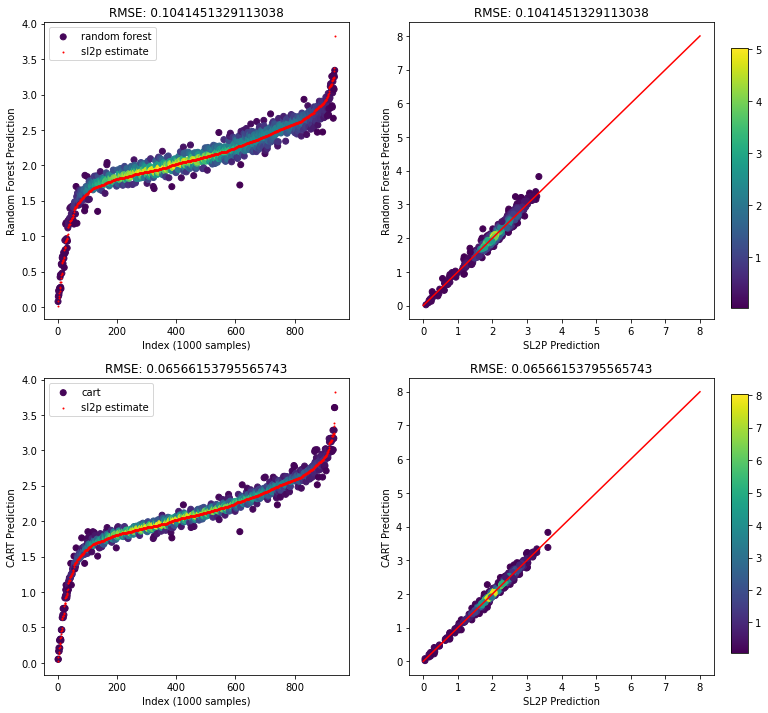

In [20]:
# PLOT & COMPARE PREDICTIONS FROM BOTH REGRESSION TREES

fig, ax = plt.subplots(2, 2, figsize=(12,12))
xy = np.linspace(0, outputMax, 100)

# ax[0,0]
fig1 = ax[0,0].scatter(index_sorted, rf_sorted, c=z_rf_sorted, label='random forest')
ax[0,0].scatter(index_sorted, actual_sorted, c='r', s=1, label='sl2p estimate')
rf_rmse_sorted = skl.metrics.mean_squared_error(actual_sorted, rf_sorted, squared=False)
ax[0,0].title.set_text('RMSE: {}'.format(rf_rmse_sorted))
ax[0,0].set_xlabel('Index (1000 samples)')
ax[0,0].set_ylabel('Random Forest Prediction')
ax[0,0].legend()

# ax[0,1]
ax[0,1].plot(xy, xy, c='r')
fig2 = ax[0,1].scatter(rf, actual, c=z_rf)
rf_rmse = skl.metrics.mean_squared_error(actual, rf, squared=False)
ax[0,1].title.set_text('RMSE: {}'.format(rf_rmse))
ax[0,1].set_xlabel('SL2P Prediction')
ax[0,1].set_ylabel('Random Forest Prediction')

fig.subplots_adjust(right=0.9)
cbar_ax1 = fig.add_axes([0.92, 0.55, 0.02, 0.3])
fig.colorbar(fig2, cax=cbar_ax1)


# ax[1,0]
fig3 = ax[1,0].scatter(index_sorted, cart_sorted, c=z_cart_sorted, label='cart')
ax[1,0].scatter(index_sorted, actual_sorted, c='r', s=1, label='sl2p estimate')
cart_rmse_sorted = skl.metrics.mean_squared_error(actual_sorted, cart_sorted, squared=False)
ax[1,0].title.set_text('RMSE: {}'.format(cart_rmse_sorted))
ax[1,0].set_xlabel('Index (1000 samples)')
ax[1,0].set_ylabel('CART Prediction')
ax[1,0].legend()

# ax[1,1]
ax[1,1].plot(xy, xy, c='r')
fig4 = ax[1,1].scatter(cart, actual, c=z_cart)
cart_rmse = skl.metrics.mean_squared_error(actual, cart, squared=False)
ax[1,1].title.set_text('RMSE: {}'.format(cart_rmse))
ax[1,1].set_xlabel('SL2P Prediction')
ax[1,1].set_ylabel('CART Prediction')

fig.subplots_adjust(right=0.9)
cbar_ax3 = fig.add_axes([0.92, 0.15, 0.02, 0.3])
fig.colorbar(fig4, cax=cbar_ax3)

# save plot as .png
fig.savefig('./trees/'+siteSelect+'_'+outputName+'_rf_cart_comparison.png')

In [ ]:
'''
# display map:
m = folium.Map(location=mapCenter, zoom_start=12, height=400)
vis_params = {
    'min': 0,
    'max': 1000}

rf_layer = m.add_ee_layer(rf_classified, vis_params, 'Image')
cart_layer = m.add_ee_layer(cart_classified, vis_params, 'Image')
sl2p_layer = m.add_ee_layer(unclassified, vis_params, 'Image')

m = displayImage(m, minVal, maxVal, mapBounds)
'''

# 3 – LARS + NNET

In [18]:
# Create the export task on the server side from Earth Engine. Remember that the data will be exported to the google drive of the google
# account you used when you initiated the Earth Engine API authentication flow, so ensure that, that accounts drive is synced to the 
# gdrive folder in the same folder as this script
trimmedCollection = alr.trim_data(image=inputImage.updateMask(inputImage.select(responseBand).gt(0)),
                                  selected_features=select_features,
                                  response_band=responseBand,
                                  num_samples=10000,
                                  num_partitions=10)

exportData = ee.batch.Export.table.toDrive(collection=trimmedCollection,
                                           description=siteSelect+'_'+outputName+'_10m',
                                           fileFormat="CSV")

In [19]:
# Start the export data task
exportData.start()

# Wait loop to see if the data has finished exporting by checking with the server-side
prev_task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
print(prev_task_status)
while exportData.active():
    task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
    if(task_status != prev_task_status):
        print(task_status)
    prev_task_status = task_status
    time.sleep(5)
print(ee.data.getTaskStatus(exportData.id)[0]["state"])

READY
RUNNING
COMPLETED


### Note:
This will create a .csv in the user's google drive folder that must be put into the 'gdrive' folder inside this directory so it can be used in the next section.

In [20]:
# Read the CSV file into dataframes
trimmed_data = pd.read_csv('./gdrive/'+siteSelect+'_'+outputName+'_10m.csv')
X = trimmed_data.drop(labels=[responseBand, 'system:index', '.geo'], axis=1)
y = trimmed_data[responseBand]

# Preprocess the input features by standardizing them to a mean of 0 and a standard deviation of 1 for the neural network
X = pd.DataFrame(skl.preprocessing.scale(X))

In [21]:
# Use Keras to create a sequential model neural network which only has simple dense layers of the specified number of nodes
model = alr.make_nets(X, y)

2021-11-22 08:19:33.176190: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-22 08:19:33.528184: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
230/230 [==============================] - 2s 1ms/step - loss: 3.1742 - mse: 3.1742 - mae: 1.7327
Epoch 2/100
230/230 [==============================] - 0s 1ms/step - loss: 0.5116 - mse: 0.5116 - mae: 0.6092
Epoch 3/100
230/230 [==============================] - 0s 1ms/step - loss: 0.1477 - mse: 0.1477 - mae: 0.2888
Epoch 4/100
230/230 [==============================] - 0s 1ms/step - loss: 0.0742 - mse: 0.0742 - mae: 0.1969
Epoch 5/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0563 - mse: 0.0563 - mae: 0.1793
Epoch 6/100
230/230 [==============================] - 0s 1ms/step - loss: 0.0480 - mse: 0.0480 - mae: 0.1693
Epoch 7/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0430 - mse: 0.0430 - mae: 0.1611
Epoch 8/100
230/230 [==============================] - 0s 1ms/step - loss: 0.0407 - mse: 0.0407 - mae: 0.1560
Epoch 9/100
230/230 [==============================] - 0s 2ms/step - loss: 0.0359 - mse: 0.0359 - mae: 0.1466
Epoch 10/1

In [22]:
# Predict our input data to evaluate the performance (for now)
predictions = pd.Series(model.predict(X.to_numpy()).flatten())

In [23]:
# Prepare data to display as a scatterplot
xy_tf = np.vstack([y, predictions])
z_tf = scipy.stats.gaussian_kde(xy_tf)(xy_tf)

idx_tf = z_tf.argsort()
x_tf = y[idx_tf]
y_tf = predictions[idx_tf]
z_tf = z_tf[idx_tf]

rmse_tf = skl.metrics.mean_squared_error(x_tf, y_tf, squared=False)

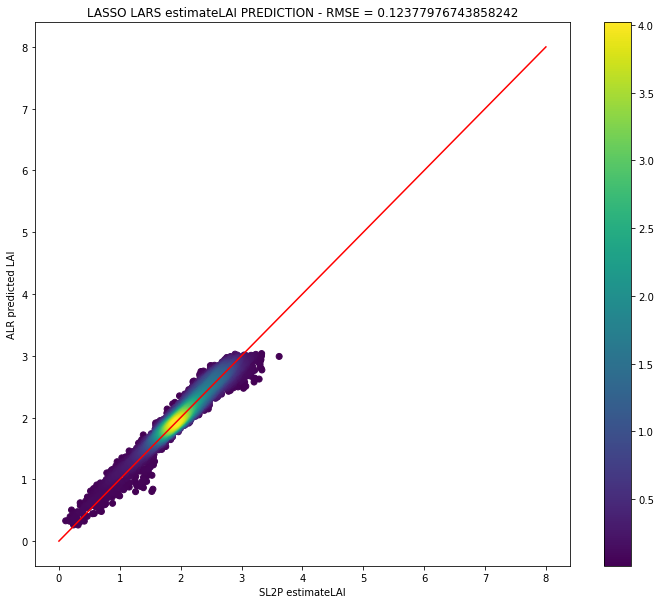

In [24]:
a_tf = np.linspace(0, outputMax, 1000)
fig, ax = plt.subplots(1, 1, figsize=(12,10))

fig1 = ax.scatter(x_tf, y_tf, c=z_tf)
ax.plot(a_tf, a_tf, c='r')
ax.set_xlabel('SL2P {}'.format(responseBand))
ax.set_ylabel('ALR predicted {}'.format(outputName))
plt.colorbar(mappable=fig1, ax=ax)

ax.title.set_text('LASSO LARS {} PREDICTION - RMSE = {}'.format(responseBand, rmse_tf))

In [25]:
model.get_weights()

[array([[ 0.80084485,  0.04795932,  0.40207863,  0.3172761 ,  0.01726317],
        [ 0.661941  , -0.5585098 ,  0.37674534,  0.58265436,  0.2345803 ],
        [-0.06658506,  0.11276507, -0.6797947 ,  0.42040548,  0.14742593],
        [ 0.0695419 , -0.6455768 ,  0.513709  ,  0.54300237, -0.24820828],
        [-0.07705013,  0.56337357, -0.43227553,  0.0504338 , -0.18619984]],
       dtype=float32),
 array([-1.0083526 ,  0.42501724,  0.5671023 ,  0.2004164 ,  0.02489798],
       dtype=float32),
 array([[ 0.67200905,  0.47158682,  1.0058807 , -0.3318153 ],
        [-0.9953599 , -0.88425386,  0.5514165 , -0.06144813],
        [-0.61651015, -0.71836525,  0.0680921 ,  0.17997845],
        [-0.15429184, -0.65151566, -0.44077143, -0.01085503],
        [-1.2052281 ,  0.11488113,  0.63840353, -0.18323348]],
       dtype=float32),
 array([-0.6619086 , -0.38016078, -0.12786768,  0.11888139], dtype=float32),
 array([[-0.7459743 , -0.18803714,  0.5423117 ],
        [ 0.35259923,  0.9088846 , -0.581074

In [26]:
elu = np.vectorize(alr.elu)
softplus = np.vectorize(alr.softplus)
softsign = np.vectorize(alr.softsign)
relu = np.vectorize(alr.relu)
tanh = np.vectorize(alr.tanh)
sigmoid = np.vectorize(alr.sigmoid)

In [27]:
row = 4802
inputs = X.iloc[row, :].to_numpy()
print(model.predict(inputs.reshape((-1,5)))[0][0])
print(alr.apply_nnet(inputs, model)[0])

In [28]:
# Writing the neural network to a CSV file to be uploaded to the server side on Google Earth Engine
export_data = alr.export_nnet(model, X)
with open('nnet.csv', 'w', newline='') as csvfile:
    nnet_writer = csv.writer(csvfile)
    for layerdata in export_data:
        nnet_writer.writerow(layerdata)

In [31]:
def parse_layer(feature):
    feature = ee.Feature(feature)
    prev_layer_size = feature.getNumber("prev_layer_size")
    num_nodes = feature.getNumber("num_nodes")
    node_size = prev_layer_size.subtract(1)
    activation = feature.getString("activation")
    
    node_collection = ee.ImageCollection(ee.List.sequence(1, num_nodes)\
                        .map(lambda node: ee.ImageCollection(ee.List.sequence(ee.Number(node).toInt(), ee.Number(node)\
                                    .toInt().add(node_size.multiply(num_nodes)), num_nodes)\
                        .map(lambda index: ee.Image(feature.getNumber(ee.Number(index).toInt())))).toBands()\
                        .set({"bias": feature.getNumber(ee.Number(node).toInt().add(prev_layer_size.multiply(num_nodes)))})))
    
    return ee.List([node_collection, activation])

In [32]:
def apply_nnet_to_image(layer, net_input):
    layer = ee.List(layer)
    net_input = ee.Image(net_input)
    
    layer_nodes = ee.ImageCollection(layer.get(0))
    activation = layer.getString(1)
    
    node_outputs = layer_nodes.map(lambda node: ee.Algorithms.If(activation.compareTo("linear"), \
                        softsign(net_input.multiply(node).reduce(ee.Reducer.sum()).add(node.getNumber("bias"))), \
                        net_input.multiply(ee.Image(node)).reduce(ee.Reducer.sum()).add(ee.Image(node).getNumber("bias")))).toBands()

    return node_outputs

In [33]:
nnet = ee.FeatureCollection("users/kateharvey/nnet")
nnet_inputs = nnet.filter(ee.Filter.eq("layer_num", 0)).first()
# print(nnet_inputs.getInfo())
num_inputs = nnet_inputs.getNumber("num_nodes")

selected_features = nnet_inputs.getString("activation").split(",")

nnet = nnet.filterBounds(ee.Geometry.Point([0,0]))
layer_list = nnet.sort("layer_num").toList(nnet.size())

In [34]:
neural_net = layer_list.map(parse_layer)

In [ ]:
# validation data of values to predict:
validation_data = inputImage.select(responseBand)
nnet_inputs = scaledImage.select(select_features)

In [ ]:
# prediction bands:
nnet_inputs = scaledImage.select(select_features)

# training data:
training_data = nnet_inputs.sample(numPixels=1000)

# predictions based on training image:
# prediction_data = ee.Image(neural_net.iterate(apply_nnet_to_image, nnet_inputs)).rename("NNET")
# inputsCollection = nnet.select(selected_features.add("estimateLAI"))

In [ ]:
cart_regression = ee.Classifier.cart().setOutputMode('REGRESSION')\
                                        .train({features=inputsCollection,
                                                classProperty=responseBand,
                                                inputProperties=nnet_inputs})

regression_image = nnet_inputs.select(select_features).classify(cart_regression, 'cart_regression')

In [ ]:
mapBounds = ee.Geometry.Polygon( \
                        [[[-117, 54], \
                          [-117, 55], \
                          [-115, 55], \
                          [-115, 54]]])

ee_func.displayImage(prediction_data, 0, 1000, mapBounds)

NameError: name 'prediction_data' is not defined